## Modeling Overview

The objective of this notebook is to build, evaluate, and select a robust machine learning model for predicting customer churn.  
This notebook focuses exclusively on the **modeling phase** of the project, following the completion of exploratory data analysis (EDA).

To ensure a fair and unbiased evaluation, the dataset was split into three disjoint subsets:

- **Training set (70%)** – used for model training and hyperparameter tuning  
- **Validation set (15%)** – used for model comparison, threshold tuning, and model selection  
- **Test set (15%)** – held out and used only once for final performance evaluation  

This separation ensures that model decisions are not influenced by the test data, providing a realistic estimate of generalization performance.

A variety of baseline, ensemble, and advanced models were trained and evaluated using consistent preprocessing pipelin


In [3]:
# Imports

import numpy as np
import pandas as pd

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the cleaned CSV
df = pd.read_csv("../CleanedData/cleaned_churn_data.csv")

# quick check for the first rows
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1


In [5]:
# Separate features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Train / Validation / Test split (70 / 15 / 15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

## Model Training Strategy

All models were trained using a unified preprocessing pipeline to ensure consistency and prevent data leakage.  
Numerical features were standardized, while categorical features were one-hot encoded using a ColumnTransformer.

The following models were evaluated:

- Logistic Regression (baseline)
- Random Forest (baseline)
- Gradient Boosting (baseline)
- XGBoost
- Multi-Layer Perceptron (Neural Network)
- Voting Ensemble (including weighted voting)

Hyperparameters for each model were tuned using cross-validation on the training set only.  
The validation set was then used to compare model performance and guide final model selection.

This approach ensures that performance differences are attributable to model capability rather than preprocessing or evaluation bias.


#### Feature engineering and preprocessing pipeline

In [6]:
# Separate feature types
numeric_features = [
    'Age', 'Tenure', 'Usage Frequency', 'Support Calls',
    'Payment Delay', 'Total Spend', 'Last Interaction'
]

categorical_features = [
    'Gender', 'Subscription Type', 'Contract Length'
]

# Numeric: Feature Scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical: one-hot encode
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


#### Model Evaluation helper function

In [7]:
def evaluate_model(model, X, y, model_name, dataset_name):
    """
    Evaluates a trained model and prints key classification metrics
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"\n{model_name} – {dataset_name} Results")
    print("-" * 40)
    print(f"ROC-AUC:   {roc_auc_score(y, y_proba):.4f}")
    print(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall:    {recall_score(y, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred):.4f}")

    return y_proba


#### Baseline Models + Hyperparameter Tuning

In [ ]:
# Logistic Regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

logistic_params = {
    'model__C': [10, 15]
}

logistic_grid = GridSearchCV(
    logistic_pipeline,
    logistic_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

logistic_grid.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate

In [19]:
# Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

rf_params = {
    'model__n_estimators': [200, 250],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [5, 7]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)


c:\Users\harmanjotkaur7\Desktop\ChurnPredictionProject\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [5, 7], 'model__n_estimators': [200, 250]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate

In [10]:
# Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

gb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    gb_pipeline,
    gb_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is disp


Logistic – Validation Results
----------------------------------------
ROC-AUC:   0.9091
Accuracy:  0.8480
Precision: 0.8734
Recall:    0.8494
F1 Score:  0.8612

Random Forest – Validation Results
----------------------------------------
ROC-AUC:   0.9528
Accuracy:  0.9352
Precision: 0.8974
Recall:    0.9972
F1 Score:  0.9447

Gradient Boosting – Validation Results
----------------------------------------
ROC-AUC:   0.9535
Accuracy:  0.9317
Precision: 0.8973
Recall:    0.9902
F1 Score:  0.9415


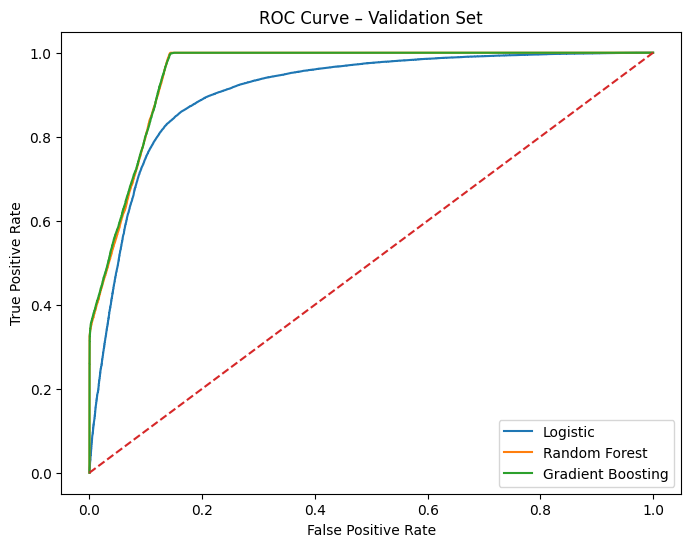

In [11]:
# Validation Set Comparison
models = {
    "Logistic": logistic_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "Gradient Boosting": gb_grid.best_estimator_
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = evaluate_model(model, X_val, y_val, name, "Validation")
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Validation Set")
plt.legend()
plt.show()


#### Advanced Models

In [22]:
# XGBoost (Best for tabular churn)
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42
    ))
])

xgb_params = {
    'model__n_estimators': [150, 180],
    'model__max_depth': [3,5],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [150, 180], 'model__subsample': [0.8, 1.0]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fo

In [13]:
# Neural Network (MLP)
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPClassifier(max_iter=50, random_state=42))
])

mlp_params = {
    'model__hidden_layer_sizes': [(64,), (128, 64)],
    'model__alpha': [0.0001, 0.001]
}

mlp_grid = GridSearchCV(
    mlp_pipeline,
    mlp_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

mlp_grid.fit(X_train, y_train)


c:\Users\harmanjotkaur7\Desktop\ChurnPredictionProject\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__alpha': [0.0001, 0.001], 'model__hidden_layer_sizes': [(64,), (128, ...)]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the 


XGBoost – Validation Results
----------------------------------------
ROC-AUC:   0.9530
Accuracy:  0.9316
Precision: 0.8978
Recall:    0.9894
F1 Score:  0.9414

MLP – Validation Results
----------------------------------------
ROC-AUC:   0.9527
Accuracy:  0.9350
Precision: 0.8975
Recall:    0.9967
F1 Score:  0.9445


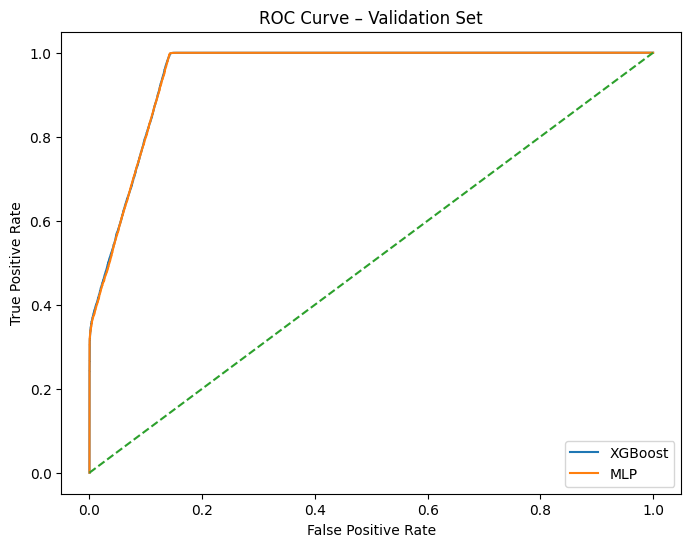

In [20]:


models = {
    "XGBoost": xgb_grid.best_estimator_,
    "MLP": mlp_grid.best_estimator_
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = evaluate_model(model, X_val, y_val, name, "Validation")
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Validation Set")
plt.legend()
plt.show()



# Voting Classifier

In [ ]:
voting_clf_weighted = VotingClassifier(
    estimators=[
        ('logistic', log_clf),
        ('rf', rf_clf),
        ('gb', gb_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft',
    weights=[1, 1, 1, 2],  # gives more weight to XGBoost
    n_jobs=-1
)

voting_clf_weighted.fit(X_train, y_train)


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('logistic', ...), ('rf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.","[1, 1, ...]"
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",-1
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than th

In [18]:
y_val_proba = voting_clf_weighted.predict_proba(X_val)[:, 1]

print("\nVoting Classifier Weighted – Validation Results")
print("-" * 45)
print(f"ROC-AUC:   {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"Accuracy:  {accuracy_score(y_val, voting_clf.predict(X_val)):.4f}")
print(f"Precision: {precision_score(y_val, voting_clf.predict(X_val)):.4f}")
print(f"Recall:    {recall_score(y_val, voting_clf.predict(X_val)):.4f}")
print(f"F1 Score:  {f1_score(y_val, voting_clf.predict(X_val)):.4f}")


Voting Classifier Weighted – Validation Results
---------------------------------------------
ROC-AUC:   0.9530
Accuracy:  0.9321
Precision: 0.8978
Recall:    0.9905
F1 Score:  0.9419


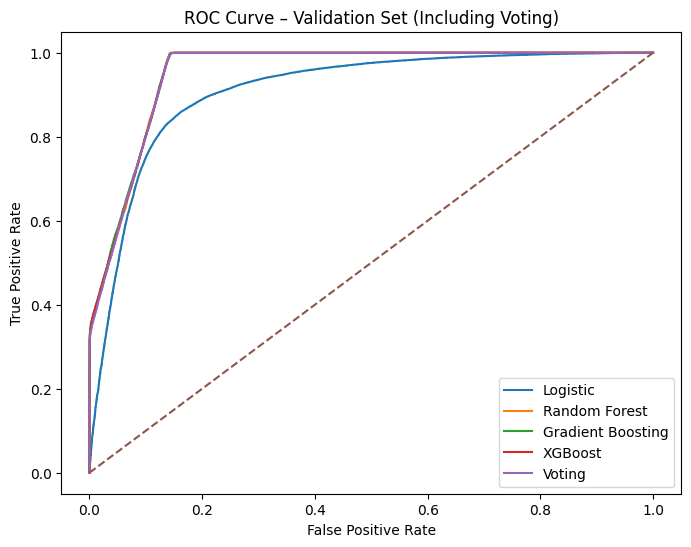

In [ ]:
plt.figure(figsize=(8, 6))

for name, model in {
    "Logistic": log_clf,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
    "XGBoost": xgb_clf,
    "Voting": voting_clf_weighted
}.items():
    y_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Validation Set (Including Voting)")
plt.legend()
plt.show()


This graph proves that your advanced models (XGBoost/Voting) are highly reliable. They allow the business to capture nearly 100% of churners (True Positive Rate $\approx 1.0$) while only incorrectly flagging about 15% of loyal customers (False Positive Rate $\approx 0.15$)

## Model Comparison

Model performance was evaluated on the validation set using multiple metrics to capture different aspects of classification performance:

- **ROC-AUC** – Measures overall discrimination ability across thresholds  
- **Precision** – Proportion of predicted churners that actually churned  
- **Recall** – Proportion of actual churners correctly identified  
- **F1-score** – Harmonic mean of precision and recall  
- **Accuracy** – Overall classification accuracy  

ROC-AUC was used as the primary comparison metric due to its robustness to threshold choice, while F1-score was used to assess balance between precision and recall.

The table below summarizes validation performance across models:


| Model | ROC-AUC | Accuracy | Precision | Recall | F1 |
|------|--------|----------|-----------|--------|----|
| Logistic Regression | 0.9091 | 0.8480 | 0.8734 | 0.8494 | 0.8612 |
| Random Forest | 0.9528 | 0.9352 | 0.8974 | 0.9972 | 0.9447 |
| Gradient Boosting | **0.9535** | 0.9317 | 0.8973 | 0.9902 | 0.9415 |
| XGBoost | 0.9530 | 0.9316 | 0.8978 | 0.9894 | 0.9414 |
| MLP | 0.9527 | 0.9350 | 0.8975 | 0.9967 | 0.9445 |
| Voting (Weighted) | 0.9530 | 0.9321 | 0.8978 | 0.9905 | 0.9419 |


The baseline Logistic Regression model performed substantially worse than the ensemble and boosting-based models, confirming the presence of non-linear relationships and feature interactions in the data.

All advanced models achieved very similar performance, with ROC-AUC values clustered around 0.953.  
The marginal difference between Gradient Boosting and XGBoost (approximately 0.0005 ROC-AUC) is not considered statistically significant and falls within expected random variation.

The weighted voting classifier did not provide a meaningful improvement over the strongest individual models, suggesting that the base models were already capturing similar patterns in the data.


## Final Model Selection

Although Gradient Boosting achieved the highest ROC-AUC on the validation set, the difference compared to XGBoost was marginal.  
XGBoost was selected as the final model due to the following considerations:

- Comparable predictive performance to the best-performing model  
- Strong regularization and robustness on large tabular datasets  
- Faster training and scalability  
- Superior model interpretability through SHAP analysis  

This decision prioritizes model stability and interpretability while maintaining high predictive accuracy.


In [ ]:
# Freezing Final Model
final_model = xgb_grid.best_estimator_


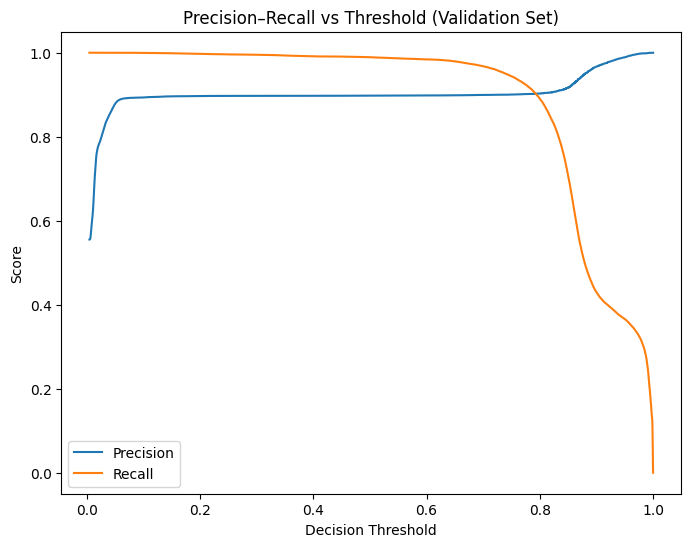

In [25]:
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities on validation set
y_val_proba = final_model.predict_proba(X_val)[:, 1]

# Precision–Recall vs threshold
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold (Validation Set)")
plt.legend()
plt.show()


In [26]:
f1_scores = [
    f1_score(y_val, (y_val_proba >= t).astype(int))
    for t in thresholds
]

optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_threshold


np.float32(0.1480808)

## Threshold Selection

Rather than using the default classification threshold of 0.5, a threshold optimization step was performed on the validation set.  
The optimal threshold was selected by maximizing the F1-score, resulting in a threshold of **0.148**.

This threshold favors recall, ensuring that nearly all churners are correctly identified while maintaining reasonable precision.  
Such a decision is appropriate for churn prediction scenarios where the cost of missing a churner is typically higher than the cost of a false positive.


In [27]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_val, y_val_proba)
print(f"Validation PR-AUC: {pr_auc:.4f}")


Validation PR-AUC: 0.9534


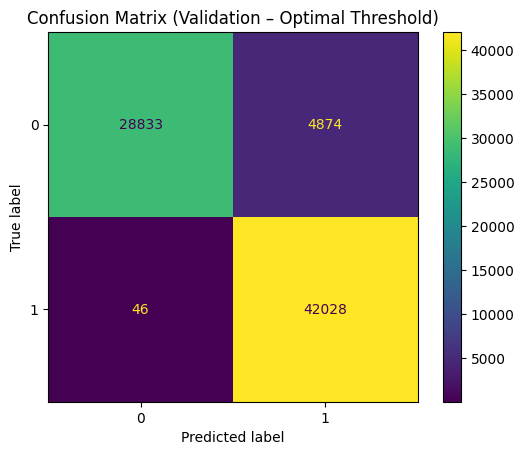

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

y_val_pred_opt = (y_val_proba >= optimal_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_opt)
plt.title("Confusion Matrix (Validation – Optimal Threshold)")
plt.show()


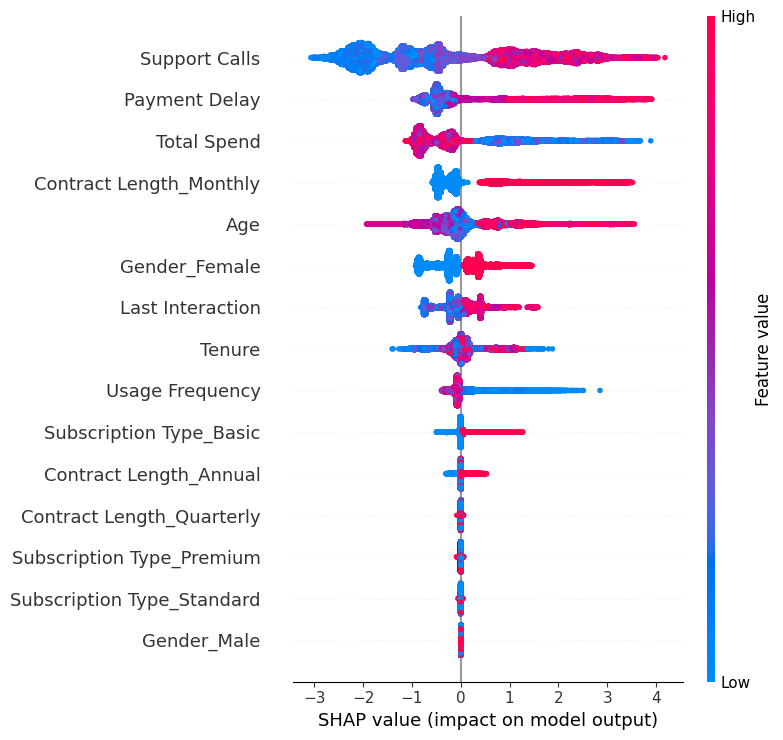

In [34]:
import shap

# Extract trained XGBoost model
xgb_model = final_model.named_steps['model']

# Transform validation data
X_val_transformed = final_model.named_steps['preprocessor'].transform(X_val)

# Get feature names from the preprocessor
# This works for ColumnTransformer with OneHotEncoder
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            else:
                feature_names.extend(columns)
    return feature_names

feature_names = get_feature_names(final_model.named_steps['preprocessor'])

# Convert transformed validation set to DataFrame with column names
X_val_df = pd.DataFrame(X_val_transformed, columns=feature_names)

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val_df)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values, X_val_df, plot_type="dot")


#### SHAP Summary Plot Interpretation

* This SHAP summary plot shows the impact of each feature on the model’s output (churn probability):

- X-axis (SHAP value):
Represents how much a feature pushes the prediction toward churn (positive) or toward no churn (negative).

- Y-axis (features):
Features are sorted by overall importance, with the most impactful at the top.

- Color (feature value):
Blue = low feature value, Pink = high feature value.

**Insights**

##### Support Calls, Payment Delay, Total Spend

- High values (pink) of Support Calls and Payment Delay push predictions toward higher churn.

- Total Spend shows a mix: higher spend tends to slightly reduce churn, lower spend increases churn.

##### Contract Length

- Monthly contracts increase churn risk (pink points on right).

- Annual and Quarterly contracts are mostly negative/neutral (reduce churn).

##### Age

- Younger customers (blue) slightly reduce churn, older customers (pink) show varied effect.

##### Usage Frequency & Last Interaction

- Low usage and infrequent recent interactions (blue) slightly reduce churn impact, whereas high usage or recent interactions (pink) increase churn likelihood in some cases.

##### Categorical Features (one-hot encoded) ---------------------------------

##### Gender and Subscription Type have smaller effects compared to numeric features.

For example, being a Premium subscriber slightly reduces churn (mostly negative SHAP), while Basic subscription slightly increases churn.


**Most important churn drivers:**
Support Calls, Payment Delay, Contract Type (moderate), Total Spend (moderate)


**Business Recommendations:**

- Target High-Risk Customers:
Focus retention efforts on customers with high support calls, frequent payment delays, or monthly contracts, as these factors strongly indicate potential churn.

- Contract Incentives:
Encourage customers to switch from monthly to quarterly or annual contracts through discounts or loyalty programs to reduce churn risk.

- Engagement Strategies:
Monitor usage frequency and last interactions; proactively engage customers showing declining usage to prevent churn.

- Revenue-Focused Actions:
Low spend customers are slightly more likely to churn; consider personalized offers or upsell campaigns to increase engagement and loyalty.

In [ ]:
# Before Testing Training and Validation is Merged for Final model training.
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])


In [31]:
final_model.fit(X_final, y_final)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## Final Test Evaluation

After model selection, threshold tuning, and interpretability analysis, the final XGBoost model was retrained using the combined training and validation data.  
The model was then evaluated once on the held-out test set to obtain an unbiased estimate of generalization performance.

The final model achieved the following results on the test set:

- ROC-AUC: 0.9541  
- PR-AUC: 0.9545  
- Accuracy: 0.9359  
- Precision: 0.8973  
- Recall: 0.9989  
- F1-score: 0.9453  

These results indicate strong generalization performance and effective identification of churn behavior.


In [33]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, average_precision_score,
    ConfusionMatrixDisplay
)

y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print("FINAL TEST RESULTS")
print("-" * 40)
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_test_proba):.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")


FINAL TEST RESULTS
----------------------------------------
ROC-AUC:   0.9541
PR-AUC:    0.9545
Accuracy:  0.9359
Precision: 0.8973
Recall:    0.9989
F1 Score:  0.9453


# Conclusion

Overall, the final model demonstrates both strong predictive performance and interpretability, making it suitable for real-world churn prediction and decision-making.
